In [1]:
# this is the stochastic kriging 
import numpy as np
import pylab as py
import numexpr as ne
from numpy.linalg import cholesky, det
from numpy.linalg import inv
from scipy.linalg import lstsq 
from scipy.optimize import minimize
import sobol_seq
import warnings
from pyDOE import lhs
warnings.filterwarnings("ignore")


#%% SK
class SK:
    def __init__(self, basis_num = 2, stochastic = False, cho = True, add_noise = False, fixed_noise = 1e-8):
        
        self.basis_num = basis_num
        self.stochastic = stochastic
        self.cho = cho
        self.add_noise = add_noise
        self.fixed_noise = fixed_noise
        
    def K(self, para):
        X = self.X_train*para[1:-1]
        X_norm = np.sum(X**2, axis = -1)
        k = ne.evaluate('sigma_f2 * exp(-(A + B - 2 * C))', {
                'A' : X_norm[:,None],
                'B' : X_norm[None,:],
                'C' : np.dot(X, X.T),
                'sigma_f2':para[0]
        })
        if self.stochastic:
            k = k + np.diag(self.ep)
        elif self.add_noise:
            k = k + para[-1] * np.eye(self.X_train.shape[0])
        else: # nugget
            k = k + self.fixed_noise * np.eye(self.X_train.shape[0])
        return k

    def Ks(self, para):
        X1 = self.X_train*para[1:-1]
        X2 = self.X_test*para[1:-1]
        X1_norm = np.sum(X1**2, axis = -1)
        X2_norm = np.sum(X2**2, axis = -1)
        ks = ne.evaluate('sigma_f2 * exp(-(A + B - 2 * C))', {
                'A' : X1_norm[:,None],
                'B' : X2_norm[None,:],
                'C' : np.dot(X1, X2.T),
                'sigma_f2':para[0]
        })
        return ks
    
    def Kss(self, para):
        X = self.X_test*para[1:-1]
        X_norm = np.sum(X**2, axis = -1)
        kss = ne.evaluate('sigma_f2 * exp(-(A + B - 2 * C))', {
                'A' : X_norm[:,None],
                'B' : X_norm[None,:],
                'C' : np.dot(X, X.T),
                'sigma_f2':para[0]
        })
        return kss
    
    def H(self, X):
        if X.shape[1] > 1:
            h = np.hstack([X**i for i in range(self.basis_num+1)])[:,1:]
        else:
            h = np.hstack([X**i for i in range(self.basis_num+1)])
        return h.T

    def beta_hat(self, para):
        h = self.H(self.X_train)
        k = self.K(para)
        try:
            L = cholesky(k)
            self.k_inv = inv(L).T.dot(inv(L))
            betahat = inv((h.dot(self.k_inv).dot(h.T))).dot(h.dot(self.k_inv).dot(self.y_train))
        except:
            self.nugget = np.diag(np.random.normal(0, 1, size = h.shape[0]))
            betahat = inv((h.dot(self.k_inv).dot(h.T)) + self.nugget).dot(h.dot(self.k_inv).dot(self.y_train))
            self.ck_problem = k
            self.para_problem = para
            print('betahat problem!')
            raise
        return betahat
        
    def neg_log_likelihood_basis(self):
        def non_cholesky(para):
            k = self.K(para)
            h = self.H(self.X_train)
            beta = self.beta_hat(para)
            L1 =  0.5 * np.log(det(k)) + \
                  0.5 * (self.y_train - h.T.dot(beta)).T.dot(inv(k).dot(self.y_train - h.T.dot(beta))) + \
                  0.5 * len(self.X_train) * np.log(2*np.pi) 
            return L1
        def with_cholesky(para):
            k = self.K(para)
            h = self.H(self.X_train)
            beta = self.beta_hat(para)
            
            L = cholesky(k)
            
            try:
                Z = lstsq(L, self.y_train - h.T.dot(beta), cond = None, lapack_driver = 'gelsy')[0]
            except:
                self.L_problem = L
                self.k_problem = k
                self.h_problem = h
                self.beta_problem = beta
                raise
                
            L2 = np.sum(np.log(np.diagonal(L))) + \
                         0.5 * Z.T.dot(Z) + \
                         0.5 * len(self.X_train) * np.log(2*np.pi)
            return L2

        if self.cho:
            return with_cholesky
        else:
            return non_cholesky
    
    def fit(self, X_train, y_train, ep = None, rangeX = [], ifscale = True):
        # scale
        self.ifscale = ifscale
        if self.ifscale:
            if len(rangeX) == 0:
                self.minX = np.min(X_train, axis = 0)
                self.maxX = np.max(X_train, axis = 0)
            else:
                self.minX = rangeX[0]
                self.maxX = rangeX[1]

            self.X_train = (X_train - self.minX)/(self.maxX - self.minX)
            self.y_train = y_train.ravel()
        else:
            self.X_train = X_train
            self.y_train = y_train.ravel()
        
        # flattern if not
        if self.stochastic:
            self.ep = ep.ravel()
            
        _ = 1e8
        for i in range(3):
            # print(f'======== In optimizer {i+1} ============')
            self.para_ = np.random.uniform(1e-2, 1e1, size = self.X_train.shape[1] + 2)
            res = minimize(self.neg_log_likelihood_basis(), 
                           self.para_, 
                           bounds = [(1e-5, None) for i in range(self.X_train.shape[1] + 2)],
                           method = 'L-BFGS-B', options = {'maxiter':5000})
            # print(res.message)
            # print(f'optimize success: {res.success}')
            if res.fun < _:
                    # print('para updated')
                    _ = res.fun
                    self.para = res.x
#        print(f'condition number of K = {np.linalg.cond(self.K(self.para))}')
            
    def predict(self, X_test, imse = False, ifcov = False):
        # scale
        if self.ifscale:
            self.X_test = (X_test - self.minX)/(self.maxX - self.minX)
        else:
            self.X_test = X_test
            
        k = self.K(self.para)
        ks = self.Ks(self.para)
        kss = self.Kss(self.para) 
        h = self.H(self.X_train)
        hs = self.H(self.X_test)
        beta = self.beta_hat(self.para)
        
        if self.cho:
            L = cholesky(k)
            k_inv = inv(L).T.dot(inv(L))
            R = hs - h.dot(k_inv).dot(ks)
            alpha = lstsq(L.T, lstsq(L, self.y_train - h.T.dot(beta), cond = None)[0], cond = None, lapack_driver = 'gelsy')[0]
            v = lstsq(L, ks, cond = None, lapack_driver = 'gelsy')[0]
            mu = hs.T.dot(beta) + ks.T.dot(alpha)
            try:
                cov = kss - v.T.dot(v) + R.T.dot(inv(h.dot(k_inv).dot(h.T))).dot(R)
            except:
                cov = kss - v.T.dot(v) + R.T.dot(inv(h.dot(k_inv).dot(h.T) + self.nugget)).dot(R)
                print('cov problem!')
        else: 
            k_inv = inv(k)
            R = hs - h.dot(k_inv).dot(ks)
            mu = ks.T.dot(k_inv).dot(self.y_train) + R.T.dot(beta)
            try:
                cov = kss - ks.T.dot(k_inv).dot(ks) + R.T.dot(inv(h.dot(k_inv).dot(h.T))).dot(R)
            except:
                cov = kss - ks.T.dot(k_inv).dot(ks) + R.T.dot(inv(h.dot(k_inv).dot(h.T) + self.nugget)).dot(R)
        if imse:    
            return np.diag(cov)
        elif ifcov:
            return mu.ravel(), cov
        else:
            return mu.ravel(), np.diag(cov)
   
    def IMSE(self, a, b, x_new = []):
        if len(x_new) != 0:
            x_new = (x_new - self.minX)/(self.maxX - self.minX)
            x_new = x_new.reshape([1,-1])
            self.X_train = np.vstack([self.X_train, x_new])
        ss = sobol_seq.i4_sobol_generate(self.X_train.shape[1], 2000)
        ss = (b - a)*ss + a
        imse = np.mean(self.predict(ss, imse = True)* np.prod(b-a))
        return imse
    
    def IMSE_local(self, a, b, sig_tol, T, x_new = []):
        if len(x_new) != 0:
            x_new = (x_new - self.minX)/(self.maxX - self.minX)
            x_new = x_new.reshape([1,-1])
            self.X_train = np.vstack([self.X_train, x_new])
        ss = sobol_seq.i4_sobol_generate(self.X_train.shape[1], 2000)
        ss = (b - a)*ss + a
        mu, cov = self.predict(ss)
        
        inner = cov * 1/np.sqrt(2*np.pi*(sig_tol**2 + cov)) * np.exp(-0.5*((mu-T)**2/(sig_tol**2 + cov)))
        imse_local = np.mean(inner*np.prod(b-a))
        return imse_local


In [2]:
# this is to calculate the real value of lamda by tfem
import numpy as np
from scipy.integrate import quad as integrate
import pylab as py
# from numba import jit
from tqdm import tqdm

def phi(f, i, tj, w = False):
    if f == 0:
        phi1 = lambda x: 0
        phi2 = lambda x: 0
        phi3 = lambda x: 0
    else:
        if w:
            phi1 = lambda x: f*(1 - 23*(x/tj)**2 + 66*(x/tj)**3 -68*(x/tj)**4 + 24*(x/tj)**5) * ((x/tj) - 1/2)
            phi2 = lambda x: f*(16*(x/tj)**2 - 32*(x/tj)**3 + 16*(x/tj)**4) * ((x/tj) - 1/2)
            phi3 = lambda x: f*(7*(x/tj)**2 - 34*(x/tj)**3 + 52*(x/tj)**4 - 24*(x/tj)**5) * ((x/tj) - 1/2)
        else:
            phi1 = lambda x: f*(1 - 23*(x/tj)**2 + 66*(x/tj)**3 -68*(x/tj)**4 + 24*(x/tj)**5)
            phi2 = lambda x: f*(16*(x/tj)**2 - 32*(x/tj)**3 + 16*(x/tj)**4)
            phi3 = lambda x: f*(7*(x/tj)**2 - 34*(x/tj)**3 + 52*(x/tj)**4 - 24*(x/tj)**5)
    
    dic = {0:phi1, 1:phi2, 2:phi3}
    return dic[i]

def dphi(f, i, tj, w = False):
    if f == 0:
        dphi1 = lambda x: 0
        dphi2 = lambda x: 0
        dphi3 = lambda x: 0
    else:
        if w:
            dphi1 = lambda x: f*(-46*(x/tj)/tj + 66*3*(x/tj)**2/tj - 68*4*(x/tj)**3/tj + 24*5*(x/tj)**4/tj) * ((x/tj) - 1/2)
            dphi2 = lambda x: f*(32*(x/tj)/tj - 32*3*(x/tj)**2/tj + 16*4*(x/tj)**3/tj) * ((x/tj) - 1/2)
            dphi3 = lambda x: f*(14*(x/tj)/tj - 34*3*(x/tj)**2/tj + 52*4*(x/tj)**3/tj - 24*5*(x/tj)**4/tj) * ((x/tj) - 1/2)
        else:
            dphi1 = lambda x: f*(-46*(x/tj)/tj + 66*3*(x/tj)**2/tj - 68*4*(x/tj)**3/tj + 24*5*(x/tj)**4/tj)
            dphi2 = lambda x: f*(32*(x/tj)/tj - 32*3*(x/tj)**2/tj + 16*4*(x/tj)**3/tj)
            dphi3 = lambda x: f*(14*(x/tj)/tj - 34*3*(x/tj)**2/tj + 52*4*(x/tj)**3/tj - 24*5*(x/tj)**4/tj)
    
    dic = {0:dphi1, 1:dphi2, 2:dphi3}
    return dic[i]




# @jit
def matfun(m, n, a, b, ksi, w, wn, k):
    ms = 5.3
    tj = 1/a/m * 60
    B = np.array([[0, 0],
                  [k*w*b/ms, 0]])
    A = np.array([[0, 1],
                  [-(k*w*b/ms + wn**2), -2*ksi*wn]])
    II = np.eye(n)
    N = np.zeros([2,2])
    P = np.zeros([2,2])
    NN = np.zeros([4,6])
    PP = np.zeros([4,6])
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(II[i,j], 0, tj) 
            ff2 = phi(A[i,j], 0, tj)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 0, tj)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[0:2,0:2] = N
    PP[0:2,0:2] = P
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(1, 1, tj) 
            ff2 = phi(A[i,j], 1, tj)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 1, tj)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[0:2,2:4] = N
    PP[0:2,2:4] = P
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(II[i,j], 2, tj) 
            ff2 = phi(A[i,j], 2, tj)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 2, tj)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[0:2,4:] = N
    PP[0:2,4:] = P
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(II[i,j], 0, tj, w = True) 
            ff2 = phi(A[i,j], 0, tj, w = True)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 0, tj, w = True)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[2:4,0:2] = N
    PP[2:4,0:2] = P
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(II[i,j], 1, tj, w = True) 
            ff2 = phi(A[i,j], 1, tj, w = True)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 1, tj, w = True)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[2:4,2:4] = N
    PP[2:4,2:4] = P
    
    for i in range(2):
        for j in range(2):
            ff1 = dphi(II[i,j], 2, tj, w = True) 
            ff2 = phi(A[i,j], 2, tj, w = True)
            N[i,j] = integrate(ff1, 0, tj)[0] - integrate(ff2, 0, tj)[0]
            gg = phi(B[i,j], 2, tj, w = True)
            P[i,j] = integrate(gg, 0, tj)[0]
    NN[2:4,4:] = N
    PP[2:4,4:] = P
    return NN, PP
    
# @jit
def tfem(a, b, ksi, w, wn, k):
    delay = 1/a*60  
    m = 40 + np.int(np.ceil(150*delay))
    n = 2
    sz = m*4+2
    H = np.zeros([sz,sz])
    G = np.zeros([sz,sz])
    H[0:2,0:2] = np.eye(n)
    G[0:2,sz-2:] = np.eye(n)
    
    NN, PP = matfun(m, n, a, b, ksi, w, wn, k) 
    for i in range(1,m+1):
        H[2+(i-1)*4:6+(i-1)*4, (i-1)*4:6+(i-1)*4] = NN;
        G[2+(i-1)*4:6+(i-1)*4, (i-1)*4:6+(i-1)*4] = PP;
   
    
    V = np.linalg.solve(H,G)
    lam = np.linalg.eigvals(V)
    rho = np.max(np.real(np.log(lam)))/delay
    return rho

In [3]:
#this part for sk to receive the training data
def get_X_train_ini(X1, X2, X, rho, N,stochastic=False,rho_std=None):
    S = lhs(2, samples = N, criterion = 'maximin')
    # map
    a_1 = (X1[-1] - X1[0]) * S[:,0].reshape([-1,1]) + X1[0]
    b_1 = (X2[-1] - X2[0]) * S[:,1].reshape([-1,1]) + X2[0]
    X_train_ini = np.hstack([a_1, b_1])
    # find the closest in  grid
    X_arg = np.array([np.argmin(np.linalg.norm(i - X, axis = 1, keepdims = True)) for i in X_train_ini])
    if stochastic:
        X_train_ini = X[X_arg] 
        y_train_ini = rho[X_arg]
        y_train_std = rho_std[X_arg]
        return X_train_ini, y_train_ini,y_train_std

    else:
        X_train_ini = X[X_arg] 
        y_train_ini = rho[X_arg]
        return X_train_ini, y_train_ini

#this part for getting the grid or the resolution of input 
def get_grid(X1, X2):
    X1, X2 = np.meshgrid(X1, X2)
    X1 = X1.reshape([-1,1])
    X2 = X2.reshape([-1,1])
    X = np.hstack([X1, X2]) # 10000 x 1
    return X

# EI is to find the estimated input surface  
def EI(mu, sigma, ep, rho):
    f_p = np.min(np.abs(ep - rho))
    f = np.abs(ep - mu)
    Phi = scipy.stats.norm.cdf((f_p - f)/sigma) 
    phi = scipy.stats.norm.pdf((f_p - f)/sigma) 
    ei = sigma*phi + (f_p - f)*Phi 
    return ei

In [4]:
import numpy as np
rho_ = np.load('./real_rho_data.npy')
rho_std=np.load('./real_rho_std.npy')
rho = rho_.reshape((10000,))
std_rho=rho_std.reshape((10000,))
rho_var=np.square(std_rho)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


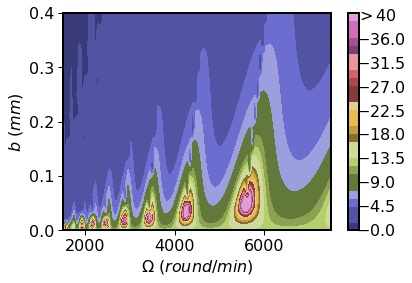

In [5]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import pylab as py
# plot setting
py.rcParams['xtick.labelsize'] = 16
py.rcParams['ytick.labelsize'] = 16
py.rcParams['font.size'] = 16
#font = {'family':'serif','size':16}
font = {'family':'serif','size':16, 'serif': ['computer modern roman'],'weight':'normal'}
py.rc('font',**font)
py.rcParams["font.weight"] = 'normal'
py.rcParams["axes.labelweight"] = 'normal'
py.rcParams['axes.linewidth'] = 2

n=100
# range
X_min = np.array([1500, 0])
X_max = np.array([7500, 40e-2])
# design variable 
X1 = np.linspace(X_min[0], X_max[0], n)
X2 = np.linspace(X_min[1], X_max[1], n) 
# design variable grid 100 x 100
X = get_grid(X1, X2)


new_rho_var=np.array([40 if i>40 else i for i in rho_var])
py.figure(facecolor='white')
a_var=py.contourf(X1, X2, new_rho_var.reshape((100,100)), levels = 30,cmap='tab20b')
#py.contour(alist, blist, rho_, levels = [0], colors = 'k', linewidths = 3)
cbar=py.colorbar(a_var)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$-0.0$','$-4.5$','$-9.0$','$-13.5$','$-18.0$','$-22.5$','$-27.0$','$-31.5$','$-36.0$',"$>40$"]):
    cbar.ax.text(30, (4.45 * j-1 ), lab)
cbar.ax.get_yaxis().labelpad = 15

py.xlim([1500, 7500])
py.ylim([0, 40e-2])
py.grid(b=None)
ax = py.axes()
ax.grid(False)
ax.set_facecolor("white")
ax.set_xlabel(r'$Ω$' + r' $(round/min)$')
ax.set_ylabel(r'$b$' + r' $(mm)$')
ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
ax.ticklabel_format(useOffset=False, style='plain')
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)


In [6]:
X_train_ini=np.load('./X_train_ini.npy')
y_train_ini=np.load('./y_train_ini.npy')
y_pred_ini=np.load('./y_pred_ini.npy')
y_var1=np.load('./y_var1.npy')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


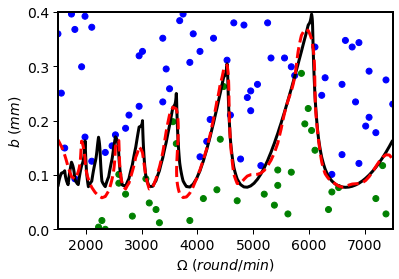

In [7]:
from scipy.stats import norm
import matplotlib.pyplot as plt
# plot setting
py.rcParams['xtick.labelsize'] = 14
py.rcParams['ytick.labelsize'] = 14
py.rcParams['font.size'] = 14
#font = {'family':'serif','size':16}
font = {'family':'serif','size':14, 'serif': ['computer modern roman'],'weight':'normal'}
py.rc('font',**font)
py.rcParams["font.weight"] = 'normal'
py.rcParams["axes.labelweight"] = 'normal'
py.rcParams['axes.linewidth'] = 2

n=100
num_reproduct=500
# range of the simulation
alist = np.linspace(1500, 7500, 100)
blist = np.linspace(0, 40e-2, 100)
grid_list=get_grid(alist, blist)

# range
X_min = np.array([1500, 0])
X_max = np.array([7500, 40e-2])
# design variable 
X1 = np.linspace(X_min[0], X_max[0], n)
X2 = np.linspace(X_min[1], X_max[1], n) 
# design variable grid 100 x 100
X = get_grid(X1, X2)



y_train_ini_color = ['g' if i <= 0 else 'b' for i in y_train_ini]

# true rho plot
# Set background color of the outer 
# area of the plt
py.figure(facecolor='white')
py.contour(alist, blist, rho_, levels = [0], colors = 'k', linewidths = 3)
py.contour(X1, X2, y_pred_ini.reshape((100,100)), levels = [0], colors = 'r', linewidths = 3,linestyles='dashed')
py.scatter(X_train_ini[:,0], X_train_ini[:,1], c = y_train_ini_color)
#py.xlabel(r'$Ω$' + r' $(round/min)$', fontweight='bold')
#py.ylabel(r'$b$' + r' $(m)$', fontweight='light')
py.xlim([1500, 7500])
py.ylim([0, 40e-2])
py.grid(b=None)
ax = py.axes()
ax.grid(False)
ax.set_facecolor("white")
ax.set_xlabel(r'$Ω$' + r' $(round/min)$')
ax.set_ylabel(r'$b$' + r' $(mm)$')
ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
ax.ticklabel_format(useOffset=False, style='plain')
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)

In [8]:
fssf = np.load('./FSSF.npy')
ksi_list=np.load('./ksi_list.npy')
wn_list=np.load('./wn_list.npy')
k_list=np.load('./k_list.npy')
w = 50e-3 #feed rate

In [9]:
FSSF_y_pred_=[]
FSSF_variance=[]
FSSF_X_added_=[]
FSSF_y_color_=[]
FSSF_y_var2=[]
for i in range(10):
    _y_pred_=np.load(f'./FSSF{i+1}_y_pred_.npy')
    _variance=np.load(f'./FSSF{i+1}_variance.npy')
    _X_added_=np.load(f'./FSSF{i+1}_X_added_.npy')
    _y_color_=np.load(f'./FSSF{i+1}_y_color_.npy')
    y_var2=np.load(f'./FSSF{i+1}_y_var2.npy')
    FSSF_y_pred_.append(_y_pred_)
    FSSF_variance.append(_variance)
    FSSF_X_added_.append(_X_added_)
    FSSF_y_color_.append(_y_color_)
    FSSF_y_var2.append(y_var2)

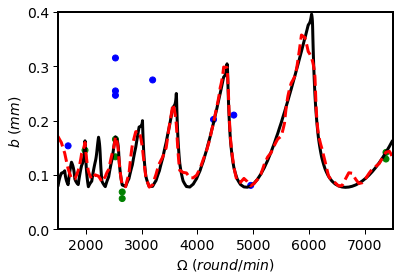

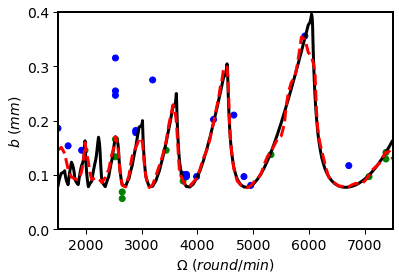

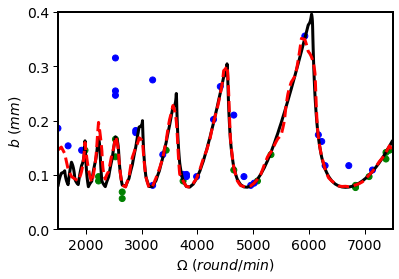

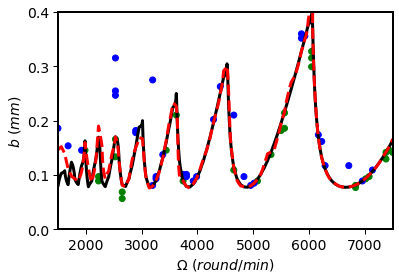

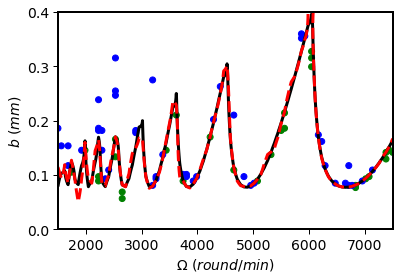

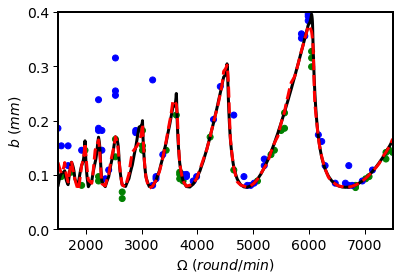

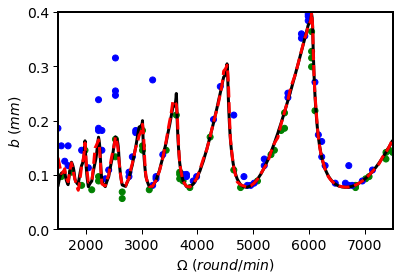

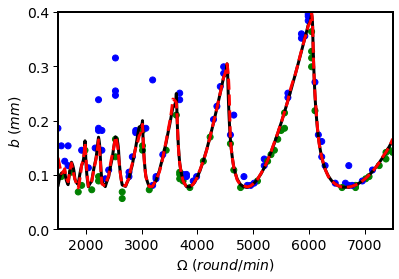

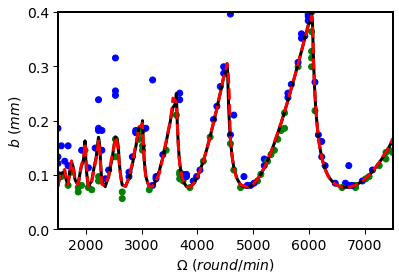

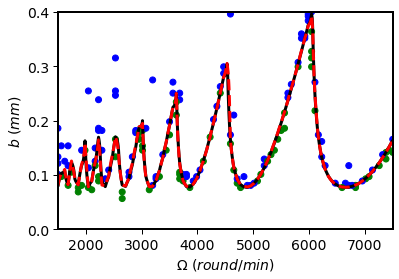

In [10]:
for i in range(10):
    py.figure(facecolor='white')
    py.contour(X1, X2, rho_, levels = [0], colors = 'k', linewidths = 3)
    py.contour(X1, X2, FSSF_y_pred_[i].reshape((100,100)), levels = [0], colors = 'r', linewidths = 3,linestyles='dashed')
    py.scatter(FSSF_X_added_[i][:,0], FSSF_X_added_[i][:,1], c = FSSF_y_color_[i])
    py.xlabel(r'$Ω$' + r' $(round/min)$')
    py.ylabel(r'$b$' + r' $(mm)$')
    py.xlim([1500, 7500])
    py.ylim([0, 40e-2])
    py.grid(b=None)
    ax = py.axes()
    ax.grid(False)
    ax.set_facecolor("white")
    ax.spines["top"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["right"].set_color("black")
    ax.spines["bottom"].set_color("black")
    py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
    py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.xaxis.set_tick_params(length=5,width=1)
    ax.yaxis.set_tick_params(length=5,width=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


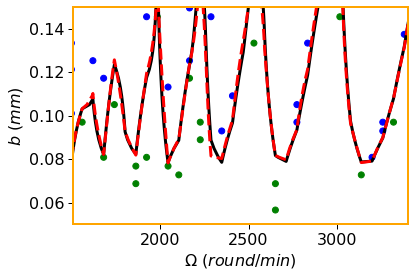

In [11]:
#zoom the 10th slice result

py.rcParams['xtick.labelsize'] = 16
py.rcParams['ytick.labelsize'] = 16
py.rcParams['font.size'] = 16
#font = {'family':'serif','size':16}
font = {'family':'serif','size':16, 'serif': ['computer modern roman']}
py.rc('font',**font)
py.rcParams["font.weight"] = 'light'
py.rcParams["axes.labelweight"] = 'light'
py.rcParams['axes.linewidth'] = 2

py.figure(facecolor='white')
py.contour(X1, X2, rho_, levels = [0], colors = 'k', linewidths = 3)
py.contour(X1, X2, FSSF_y_pred_[9].reshape((100,100)), levels = [0], colors = 'r', linewidths = 3,linestyles='dashed')
py.scatter(FSSF_X_added_[9][:,0], FSSF_X_added_[9][:,1], c = FSSF_y_color_[9])
py.xlabel(r'$Ω$' + r' $(round/min)$')
py.ylabel(r'$b$' + r' $(mm)$')
py.xlim([1510, 3400])
py.ylim([0.05, 0.15])
py.grid(b=None)
ax = py.axes()
ax.grid(False)
ax.set_facecolor("white")
ax.spines["top"].set_color("orange")
ax.spines["left"].set_color("orange")
ax.spines["right"].set_color("orange")
ax.spines["bottom"].set_color("orange")
py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
ax.ticklabel_format(useOffset=False, style='plain')
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)

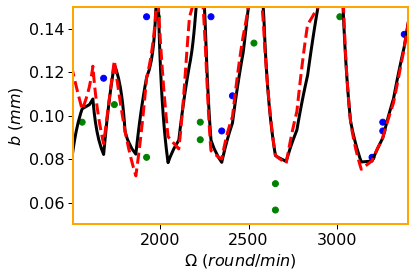

In [12]:
#zoom the 6th slice result
FSSF6_y_pred_=np.load('./FSSF6_y_pred_.npy')
FSSF6_X_added_=np.load('./FSSF6_X_added_.npy')
FSSF6_y_color_=np.load('./FSSF6_y_color_.npy')
py.figure(facecolor='white')
py.contour(X1, X2, rho_, levels = [0], colors = 'k', linewidths = 3)
py.contour(X1, X2, FSSF6_y_pred_.reshape((100,100)), levels = [0], colors = 'r', linewidths = 3,linestyles='dashed')
py.scatter(FSSF6_X_added_[:,0], FSSF6_X_added_[:,1], c = FSSF6_y_color_)
py.xlabel(r'$Ω$' + r' $(round/min)$')
py.ylabel(r'$b$' + r' $(mm)$')
py.xlim([1510, 3400])
py.ylim([0.05, 0.15])
py.grid(b=None)
ax = py.axes()
ax.grid(False)
ax.set_facecolor("white")
ax.spines["top"].set_color("orange")
ax.spines["left"].set_color("orange")
ax.spines["right"].set_color("orange")
ax.spines["bottom"].set_color("orange")
py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
ax.ticklabel_format(useOffset=False, style='plain')
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)

In [13]:
#fit GP based on the infromative design points 
X_train_=np.vstack([X_train_ini.copy(), FSSF_X_added_[-1]])
gp = SK(basis_num = 4, cho = True, stochastic = False, add_noise = True)
gp.fit(X_train_, FSSF_y_var2[-1], rangeX = [X_min, X_max])
#predict the variance of each design points
bp_pred_var, bp_var_var = gp.predict(X)
save('bp_pred_var.npy', bp_pred_var) #save the result


In [14]:
bp_pred_var=np.load("./bp_pred_var.npy")

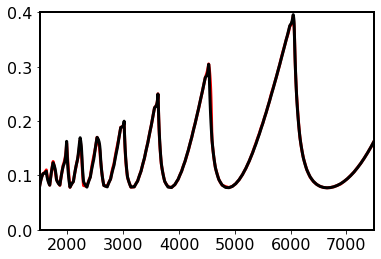

In [15]:
import random
bpl=py.contour(X1, X2, FSSF_y_pred_[-1].reshape((100,100)), levels = [0], colors = 'r', linewidths = 3)
tpl=py.contour(X1, X2, rho_, levels = [0], colors = 'k', linewidths = 3)
tps=tpl.allsegs[0][0]

bp=bpl.allsegs[0][0]

bp_arg = np.array([np.argmin( np.linalg.norm(i - X, axis = 1, keepdims = True)) for i in bp])
bp_index=np.unique(bp_arg, axis = 0)
bp_index_select=np.array(random.sample(list(bp_index), 500))
bp_near = np.unique(X[bp_arg], axis = 0)
bpn_pred_var, bpn_var_var = gp.predict(X[bp_index_select])
gp_error=np.abs(rho_var[bp_index_select]-bpn_pred_var)
var_err_sort_index = np.argsort(gp_error)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


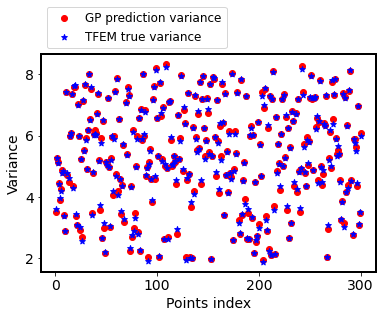

In [16]:
import matplotlib.pyplot as plt
import random
var_err_sort_index = np.argsort(gp_error)
var_pick=var_err_sort_index[:300]
index_list=np.linspace(1,300,300)
random.shuffle(index_list)
GP_var=bpn_pred_var
TFEM_var = rho_var[bp_index_select]
plt.figure(facecolor='white')
gp_var_p=plt.scatter(index_list,GP_var[var_pick],c="r", marker='o')
gp_var_p.set_label('GP prediction variance')
TFEM_var_p=plt.scatter(index_list,TFEM_var[var_pick],c="b", marker='*')
TFEM_var_p.set_label('TFEM true variance')
plt.legend(bbox_to_anchor=(0., 1, 2., 1), loc=3,fontsize=12,facecolor='white')
plt.xlabel("Points index",fontsize=14)
plt.ylabel("Variance",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(b=None)
ax = plt.axes()
ax.set_facecolor("white")
# Hide grid lines
ax.grid(False)
ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black");

In [17]:
#method 
#CVaR result and corresponding SK-active learning results
from scipy.stats import norm
def cvar(alpha,mean,std):
    res=[]
    for i in range(len(mean)):
        me,st=mean[i],std[i]
        q=norm.ppf(alpha/100,loc=me,scale=st)
        e=((1-alpha/100)**-1)*norm.expect(lambda x: x-q, loc=me, scale=st, lb=q, ub=np.inf)
        res.append(q+e)
    arr=np.asarray(res)
    return arr
res=cvar(99,FSSF_y_pred_[-1],np.sqrt(bp_pred_var))

In [18]:
def feas_area(rho,region):
    new_region=[]
    new_rho=[]
    for index,ele in enumerate(rho):
        if ele<0:
            new_region.append(region[index])
            new_rho.append(ele)
    arr_new_rho=np.asarray(new_rho)
    arr_new_region=np.asarray(new_region)
    return arr_new_rho,arr_new_region
new_rho, new_region=feas_area(res,X)

In [19]:
# get the maximum MRR and the corresponding design points
def MRR(wn,d):
    f0=5e-5
    return np.pi*(2*0.05-d)*wn*f0*d  #0.05m is the radius of the cutting

def optimal_MRR(feasible_region):
    opt_mrr=0
    
    l_feas=feasible_region.tolist()
    for ele in l_feas:
        res=MRR(ele[0],ele[1]*0.001)
        if res>=opt_mrr:
            opt_mrr=res
            location=ele
    return location,opt_mrr


loc,mrr=optimal_MRR(new_region)
print(loc)
print(mrr)

[5984.848484848485, 0.3474747474747475]
3.255251843615797e-05


In [20]:
def mrr_area(v_mrr,region,feas_region):
    res_mrr=[]
    new_regions=[]
    eff_mrr=[]
    l_X=region.tolist()
    l_feas=feas_region.tolist()
    for ele in l_X:
        if ele in l_feas:
            if MRR(ele[0],ele[1]*0.001)>=v_mrr:
                res_mrr.append(1)
                new_regions.append(ele)
            else:
                res_mrr.append(-1)
 
        else:
            res_mrr.append(-1)
            
    arr_mrr=np.asarray(res_mrr)
    arr_regions=np.asarray(new_regions)
    return arr_mrr,arr_regions
mrr_results, regions=mrr_area(0.000025,X,new_region)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


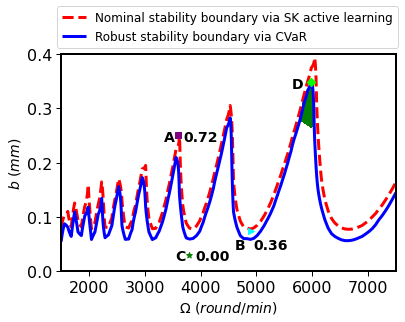

In [22]:
from decimal import Decimal
from scipy.stats import norm
X_train_tfem=np.array([[3600, 0.25],
                    [3800, 0.03],
                    [4900, 0.075]])
tfem_list=[]
for ele in range(num_reproduct):
    y_train=np.array([tfem(i[0], 0.001*i[1], ksi_list[ele], w, wn_list[ele], k_list[ele]) for i in X_train_tfem])
    tfem_list.append(y_train)
tfem_mean=np.mean(tfem_list, axis=0)
tfem_std=np.sqrt(np.var(tfem_list, axis=0))
tfem_color = [1-norm.cdf(0, loc=i[0], scale=i[1]) for i in zip(tfem_mean,tfem_std)]

tfem_prob=[Decimal(i).quantize(Decimal('0.01')) for i in tfem_color]


a=py.contourf(X1, X2, mrr_results.reshape((100,100)), 0, colors = ['w', 'green'])
sk_ac=py.contour(X1, X2, FSSF_y_pred_[-1].reshape((100,100)), levels = [0], colors = 'red', linewidths = 3,linestyles='dashed')
sk_ac.collections[0].set_label('Nominal stability boundary via SK active learning')
cvar_m=py.contour(X1, X2, res.reshape((100,100)),levels = [0], colors = 'b', linewidths = 3)
cvar_m.collections[0].set_label('Robust stability boundary via CVaR')
choosen_color=["purple","green","cyan"]
shapes=["," , "*" , ">" ]
points_name=["A","C","B"]
for i in range(len(X_train_tfem)):
    if i==2:
        py.scatter(X_train_tfem[i,0], X_train_tfem[i,1], c = choosen_color[i],zorder=2,marker=shapes[i])
        plt.annotate(tfem_prob[i],xy=(X_train_tfem[i][0]+50, X_train_tfem[i][1]-0.035), xycoords='data'
            ,textcoords='data',fontsize=14,fontweight="bold")
        plt.annotate(points_name[i],xy=(X_train_tfem[i][0]-280, X_train_tfem[i][1]-0.035), xycoords='data'
            ,textcoords='data',fontsize=14,fontweight="bold",c="black")
    else:
        py.scatter(X_train_tfem[i,0], X_train_tfem[i,1], c = choosen_color[i],zorder=2,marker=shapes[i])
        plt.annotate(tfem_prob[i],xy=(X_train_tfem[i][0]+100, X_train_tfem[i][1]-0.01), xycoords='data'
                    ,textcoords='data',fontsize=14,fontweight="bold")
        plt.annotate(points_name[i],xy=(X_train_tfem[i][0]-250, X_train_tfem[i][1]-0.01), xycoords='data'
                    ,textcoords='data',fontsize=14,fontweight="bold",c="black")
        
# show the optimal MRR  
opt_mrr=Decimal(mrr).quantize(Decimal('0.01'))
py.scatter(loc[0], loc[1], c = "lime",zorder=3,marker="D")

plt.annotate("D",xy=(loc[0]-350, loc[1]-0.01), xycoords='data'
            ,textcoords='data',fontsize=14,fontweight="bold",c="black")

py.legend(bbox_to_anchor=(-0.03, 1, 2., 1), loc=3,fontsize=12,facecolor='white')

#py.scatter(regions[:,0], regions[:,1], c = "green")
py.xlabel(r'$Ω$' + r' $(round/min)$',fontsize=14)
py.ylabel(r'$b$' + r' $(mm)$',fontsize=14)
py.xlim([1500, 7500])
py.ylim([0, 40e-2])
py.grid(b=None)
ax = py.axes()
ax.grid(False)
ax.set_facecolor("white")
ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
py.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
py.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
ax.ticklabel_format(useOffset=False, style='plain')
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


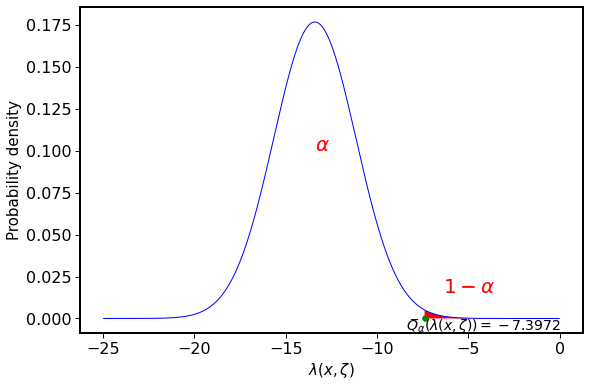

In [23]:
# normal_curve.py
import pylab as py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# if using a Jupyter notebook, inlcude:
%matplotlib inline
q=norm.ppf(99/100,loc=FSSF_y_pred_[-1][5550],scale=np.sqrt(bp_pred_var[5550]))
e=((1-99/100)**-1)*norm.expect(lambda x: x-q, loc=FSSF_y_pred_[-1][5550], scale=np.sqrt(bp_pred_var[5550]), lb=q, ub=np.inf)
Q_alpha=q+e
# define constants
mu = FSSF_y_pred_[-1][5550] 
sigma = np.sqrt(bp_pred_var[5550])
x1 = -20
x2 = Q_alpha

x = np.arange(-25, x2, 0.001) # range of x in spec
x_all = np.arange(-25, 0, 0.001) # entire range of x, both in and out of spec
x_r = np.arange(x2, 0, 0.001)
# mean = 0, stddev = 1, since Z-transform was calculated
y = norm.pdf(x,mu,sigma)
y2 = norm.pdf(x_all,mu,sigma)
y3=norm.pdf(x_r,mu,sigma)
# build the plot
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fivethirtyeight')
ax.grid(False)
ax.set_facecolor("white")
ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.plot(x_all,y2,color='blue',
     linewidth=1, markersize=0.1)

#ax.fill_between(x,y,0, alpha=0.5, color='white')
#ax.fill_between(x_all,y2,0, alpha=0.1,color='red')
ax.fill_between(x_r,y3,0, alpha=1,facecolor='red', interpolate = True)
#ax.set_xlim([-30,5])
#ax.set_ylim([0,0.2])
#ax.set_xlabel('# of Standard Deviations Outside the Mean')
#ax.set_yticklabels([]) #remove the scaler
#ax.set_xticklabels([])
py.scatter(x2, 0, c ="g")  
plt.text(x2-1, -0.007, r'$Q ̅_α (λ(x,ζ))=-7.3972$', fontsize=20,font='normal')
plt.text(mu, 0.1, r'$α$', fontsize=20,c='r')
plt.text(x2+1, 0.015, r'$1-α$', fontsize=20,c='r')
#ax.set_title('Normal Gaussian Curve')
py.xlabel(r'$λ(x,ζ)$', fontsize=15)
py.ylabel(r'Probability density', fontsize=15)
ax.xaxis.set_tick_params(length=5,width=1)
ax.yaxis.set_tick_params(length=5,width=1)
plt.show()